# Inference with TorchScript Model

This notebook demonstrates how to perform inference on histology images using a TorchScripted model. It uses utility functions and classes from `utils.py`, loads a scripted model, runs predictions on a batch, and visualizes the results with true and predicted labels.

In [1]:
# Import required libraries and utility functions
import sys
sys.path.append('../src')  # Ensure utils.py is importable
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils
from utils import get_dataset_info, get_transforms, PatchDataset, denormalize, export_torchscript_for_icy
import glob



In [ ]:
from PIL import Image  # Import the Image module from PIL

images = glob.glob('../data/Regions/**/*.png', recursive=True)  # Use recursive search
# pick a single random image
image_path = np.random.choice(images)
print(f'Using image: {image_path}')
# Save deep icy zip with image 
output_path = "../export"
# make sur e the directory exists
import os
if not os.path.exists(output_path):
    os.makedirs(output_path)

num_classes = len(next(os.walk('../data/Regions'))[1])
export_torchscript_for_icy('./best_model_scripted.pt', output_path, 'nsclc_tissue_classifier', num_classes, image_path, authors=['Student Name'], cite=['paper'])

Using image: ../data/Regions\Necrotic\B9.mrxs_roi_1_13591_24207.png
Exported model to nsclc_tissue_classifier.zip


'nsclc_tissue_classifier.zip'

## Load the TorchScript Model

We load the best scripted model saved as a `.pt` file. TorchScript models can be loaded and used for inference without needing the original class definition.

In [2]:
# Load the TorchScripted model
scripted_model_path = './best_model_scripted.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.jit.load(scripted_model_path, map_location=device)
model.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(
    original_name=ResNet
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      )
      (1): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): Rec

## Prepare the Dataset and DataLoader

We use the utility functions to get class mappings and transforms, then create a dataset and dataloader for inference.

In [6]:
# Get class info and transforms
data_dir = '../data/Regions/'
class_names, num_classes, class_to_idx, idx_to_class = get_dataset_info(data_dir)
train_transforms, val_test_transforms = get_transforms()

# Collect a list of image paths and labels for inference (using all classes, first 16 images)
import glob
from pathlib import Path

from utils import PatchDataModule
image_paths = []
labels = []
for class_name in class_names:
    class_dir = Path(data_dir) / class_name
    imgs = sorted(glob.glob(str(class_dir / '*.png')))
    image_paths.extend(imgs[:4])  # Take up to 4 images per class for demo
    labels.extend([class_name]*len(imgs[:4]))

# # Create the dataset and dataloader
# dataset = PatchDataset(image_paths, labels, transform=val_test_transforms, label_map=class_to_idx)
# from torch.utils.data import DataLoader
# dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
# use datamodule to load images

DATA_DIR = '../data/Regions/'
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15




data_module = PatchDataModule(
    data_dir=DATA_DIR,
    class_to_idx=class_to_idx, # Use the map created in the config cell
    train_transform=train_transforms,
    val_test_transform=val_test_transforms,
    batch_size=32,
    num_workers=4, # Adjust based on your system
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO
)
data_module.setup()
dataloader = data_module.test_dataloader()

Dataset directory: ../data/Regions
Found 4 classes: ['Fibrotic', 'Mucin', 'Necrotic', 'TumorIslet']
Class to index mapping: {'Fibrotic': 0, 'Mucin': 1, 'Necrotic': 2, 'TumorIslet': 3}
Defined train_transforms and val_test_transforms.
Setting up data for stage: None
Scanning for all image paths and string labels...
Found 2516 total images.
Dataset split completed.
Train size: 1761, Val size: 377, Test size: 378
Initialized Dataset. Label map: {'Fibrotic': 0, 'Mucin': 1, 'Necrotic': 2, 'TumorIslet': 3}
Initialized Dataset. Label map: {'Fibrotic': 0, 'Mucin': 1, 'Necrotic': 2, 'TumorIslet': 3}
Initialized Dataset. Label map: {'Fibrotic': 0, 'Mucin': 1, 'Necrotic': 2, 'TumorIslet': 3}
Datasets instantiated.


/home/mbenimam/Documents/work/neubias/notebooks/../src/utils.py:188: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=30, p=0.5, border_mode=cv2.BORDER_REFLECT, value=0),


## Run Inference and Visualize Results

We run the model on a batch of images, get predictions, and display a grid with both true and predicted labels.

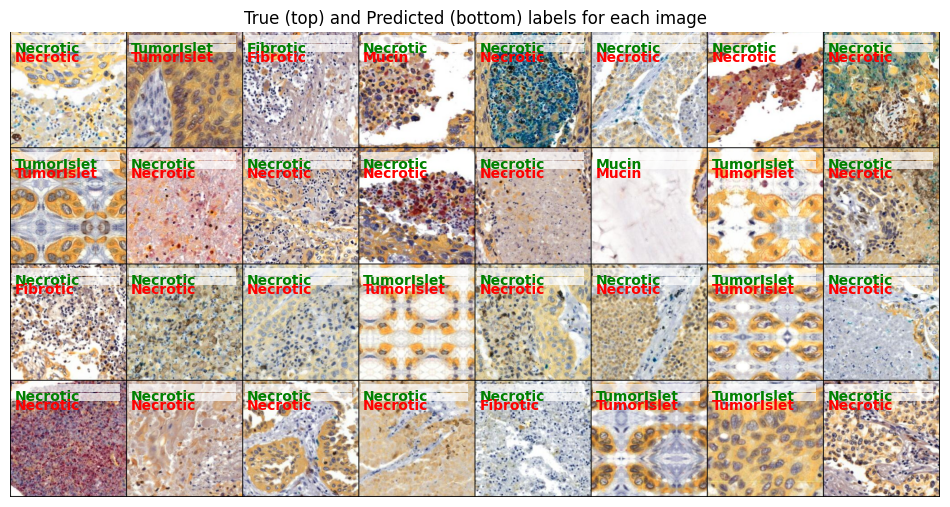

In [16]:
# Get a batch of images and labels
images, true_labels = next(iter(dataloader))
images = images.to(device)

# Run inference
with torch.no_grad():
    outputs = model(images)
    probs = outputs
    preds = torch.argmax(probs, dim=1)

# Prepare for visualization
denorm_images = [denormalize(img.cpu()) for img in images]
grid = torchvision.utils.make_grid(denorm_images, nrow=8)
grid_np = grid.permute(1, 2, 0).numpy()

# Map indices to class names
true_labels_names = [idx_to_class[int(l)] for l in true_labels]
pred_labels_names = [idx_to_class[int(p)] for p in preds.cpu()]

# Display the grid with labels
plt.figure(figsize=(12, 12))
plt.imshow(grid_np)
plt.axis('off')
plt.title('True (top) and Predicted (bottom) labels for each image')

# Show labels above and below each image
import matplotlib.patches as patches

nrow = 8
img_w = grid_np.shape[1] // nrow
img_h = grid_np.shape[0] // ((len(denorm_images) + nrow - 1) // nrow)

for i in range(len(denorm_images)):
    row, col = divmod(i, nrow)
    x = col * img_w + 10
    y_true = row * img_h + 20
    y_pred = row * img_h + 40

    # Draw rectangles for text background
    rect_true = patches.Rectangle((x - 5, y_true - 12), img_w - 20, 18, linewidth=0, edgecolor=None, facecolor='white', alpha=0.7)
    rect_pred = patches.Rectangle((x - 5, y_pred - 12), img_w - 20, 18, linewidth=0, edgecolor=None, facecolor='white', alpha=0.7)
    plt.gca().add_patch(rect_true)
    plt.gca().add_patch(rect_pred)

    plt.text(x, y_true, true_labels_names[i], color='green', fontsize=10, weight='bold', va='top')
    plt.text(x, y_pred, pred_labels_names[i], color='red', fontsize=10, weight='bold', va='top')
plt.show()

## Conclusion

This notebook showed how to load a TorchScript model, run inference on a batch of images, and visualize the results with both true and predicted labels. You can adapt this workflow for your own datasets and models.

In [20]:
# Draw a costum confusion matrix that shows the image of that specefic error case

import tqdm
# find the indices of the misclassified images (it's a nclass x nclass matrix of list of indecies)

misclassified_indices = {}
for i in range(num_classes):
    misclassified_indices[i] = {j: [] for j in range(num_classes)}
# for the entire test dataloader
for images, true_labels in tqdm.tqdm(dataloader):
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    for i in range(len(true_labels)):
        true_label = true_labels[i].item()
        pred_label = preds[i].item()
        # if true_label != pred_label:
            # Append the image tensor (move to cpu for later visualization)
        misclassified_indices[true_label][pred_label].append(images[i].cpu())

display(misclassified_indices)


  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:10<00:00,  1.16it/s]


{0: {0: [tensor([[[ 1.4783,  1.5297,  1.7694,  ...,  1.7694,  1.8208,  1.7009],
            [ 1.7523,  1.8550,  2.0605,  ...,  2.1290,  2.1462,  2.0263],
            [ 1.7180,  1.9064,  2.1290,  ...,  2.1975,  2.1633,  2.2489],
            ...,
            [-0.9705, -0.6281,  0.0741,  ...,  1.2043,  1.2385,  1.3584],
            [-0.3369, -0.2856,  0.1597,  ...,  1.1872,  1.3070,  1.2385],
            [ 1.4783,  1.6153,  1.5810,  ...,  1.2728,  1.2043,  1.1015]],
   
           [[ 1.4832,  1.5882,  1.8333,  ...,  1.8508,  1.9559,  1.8333],
            [ 1.8508,  1.9909,  2.2185,  ...,  2.2185,  2.2360,  2.1660],
            [ 1.8508,  2.0784,  2.3060,  ...,  2.2535,  2.2535,  2.3936],
            ...,
            [-1.1078, -0.7052,  0.1001,  ...,  1.0280,  1.1331,  1.2906],
            [-0.3550, -0.2500,  0.2577,  ...,  1.0455,  1.2031,  1.1331],
            [ 1.5707,  1.7633,  1.7633,  ...,  1.1681,  1.0805,  0.9755]],
   
           [[ 1.7163,  1.8034,  2.0474,  ...,  2.1868,  2.2217

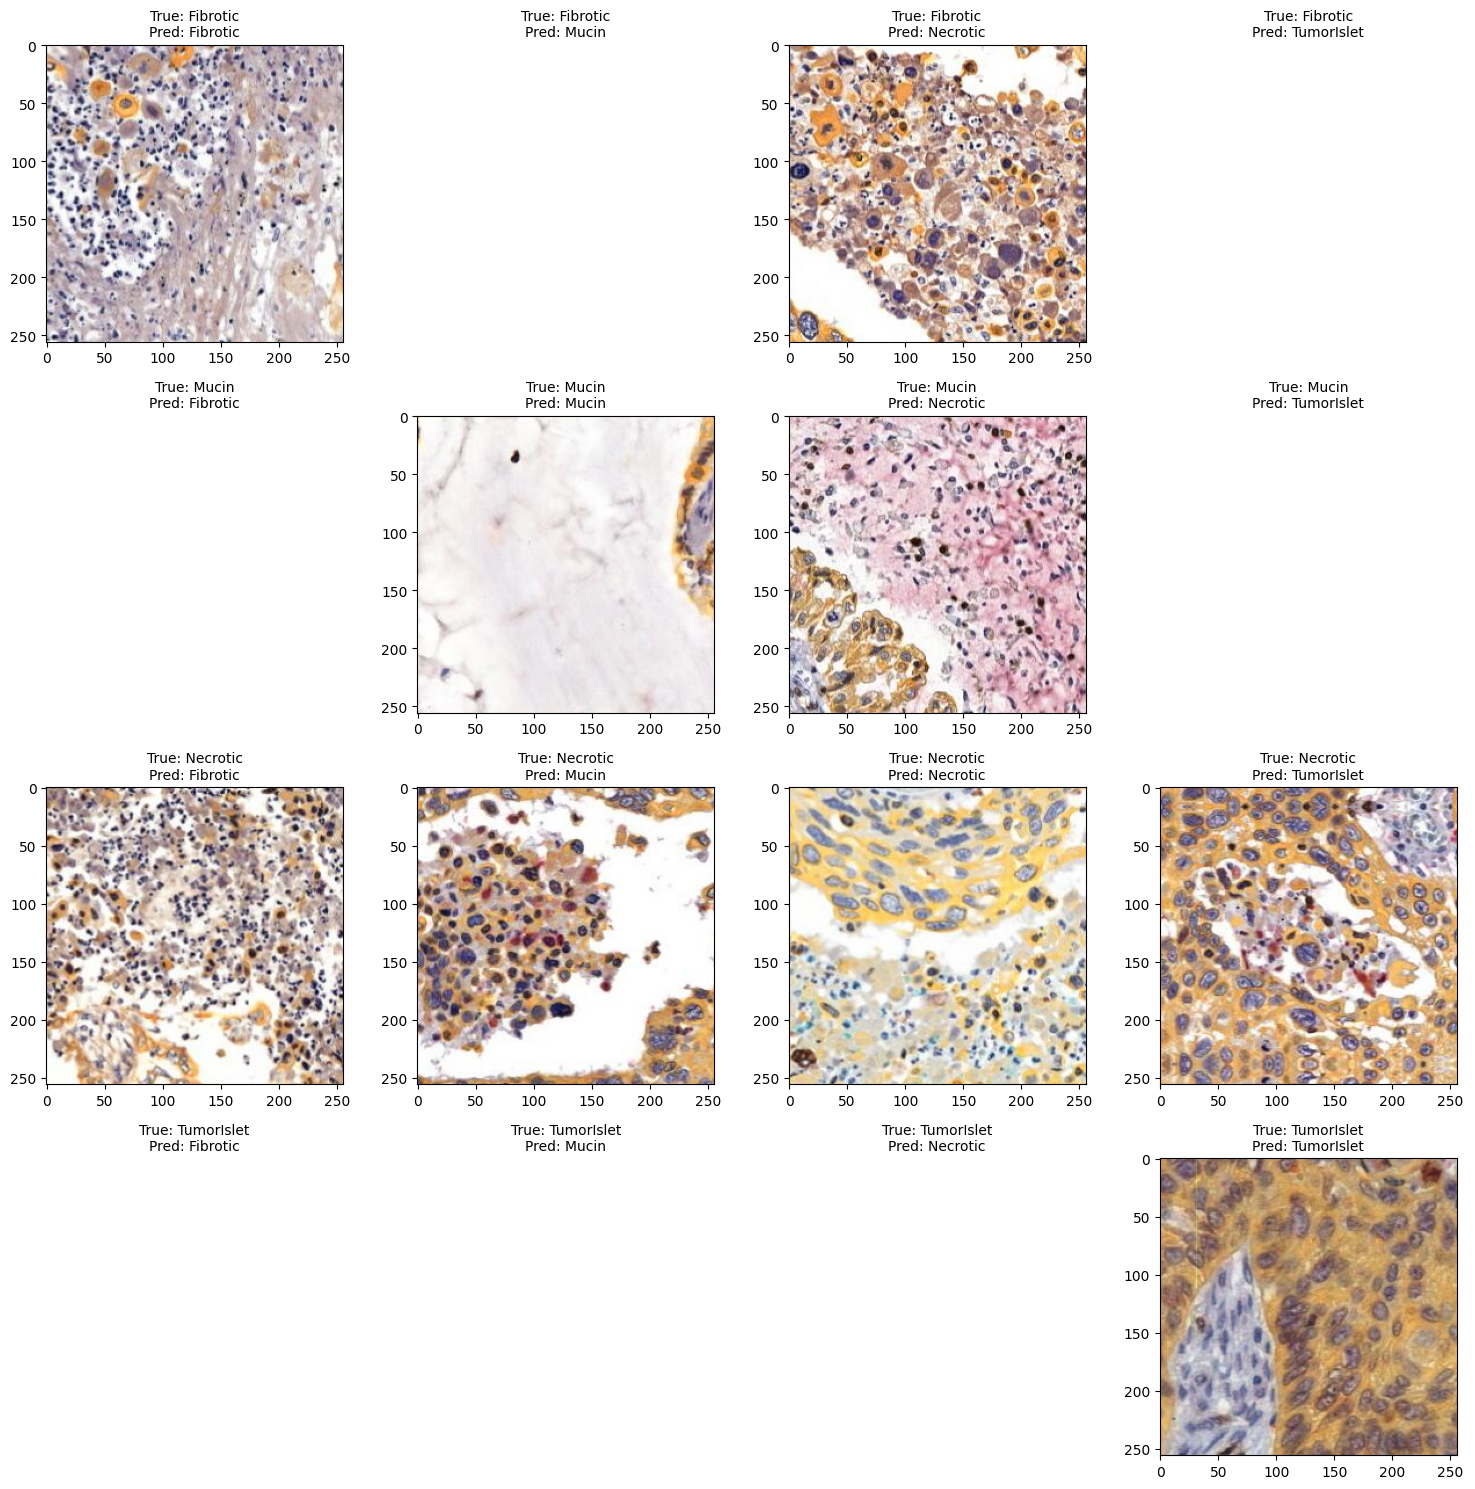

In [21]:
# show the images in a confusion matrix
def show_misclassified_images(misclassified_indices, class_names):
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, num_classes, figsize=(15, 15))
    for i in range(num_classes):
        for j in range(num_classes):
            # if i == j:
            #     axes[i, j].axis('off')
            #     continue
            if len(misclassified_indices[i][j]) > 0:
                img = misclassified_indices[i][j][0]
                img = denormalize(img)
                axes[i, j].imshow(img.permute(1, 2, 0).numpy())
            else:
                axes[i, j].axis('off')
            axes[i, j].set_title(f'True: {class_names[i]}\nPred: {class_names[j]}', fontsize=10)
    plt.tight_layout()
    plt.show()
show_misclassified_images(misclassified_indices, class_names)
# Save the figure